## Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import sys
import time
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import prepare_data

random_state = 42
results = []
partial_save_path = "results/logreg_partial_results.csv"

### 1. Load Data

In [ ]:
train_df = pd.read_csv("fraudTrain.csv")
test_df = pd.read_csv("fraudTest.csv")

### 2. Prepare Data for LINEAR Models

In [ ]:
print("Fitting encoders and scalers on train data...")
out_train_init = prepare_data(
    train_df,
    mode="linear",
    training=False,
    fit=True,
)
encoders = out_train_init["encoders"]
scalers = out_train_init["scalers"]
print("Fit complete.")

print("Preparing test set...")
out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers,
)
df_test = out_test["df"]
X_test = df_test.drop("is_fraud", axis=1)
y_test = df_test["is_fraud"]

X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

print(f"Test set prepared for linear models. Shape: {X_test.shape}")

Fitting encoders and scalers on train data...
Fit complete.
Preparing test set...
Test set prepared for linear models. Shape: (555719, 25)


### 3. Define Experiment Parameters

In [ ]:
ratios_to_test = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0] 
resample_types_to_test = ["df_up", "df_down"] 

param = {
    "name": "LogisticRegression",
	"params": {
		"random_state": random_state
	},
}


### 4. Run Experiment Loop

In [ ]:
print("\nStarting Logistic Regression experiment loop...")
for ratio_idx, ratio in enumerate(ratios_to_test, start=1):
    print(f"\n{'='*70}")
    print(
        f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios_to_test)} → ratio={ratio}"
    )
    start_ratio_time = time.time()

    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=False,  
        encoders=encoders,
        scalers=scalers,
    )

    for resample_type in resample_types_to_test:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(
            f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})"
        )
        sys.stdout.flush()


        model_name = param["name"]
        params = param["params"]
        start_k_time = time.time()

        print(f"    ⏳ Running {model_name} ...", end="")
        sys.stdout.flush()

        model = LogisticRegression(**params)
        
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Metrics
        f1 = f1_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        
        results.append(
            {
                "model": model_name,
                "ratio": ratio,
                "resample_type": resample_type.replace("df_",""),
                "accuracy": acc,
                "precision": prec,
                "recall": rec,
                "f1": f1,
            }
        )

        print(
            f" done → F1={f1:.4f}, Recall={rec:.4f} | Time={time.time() - start_k_time:.1f}s"
        )
        sys.stdout.flush()

    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")


Starting Logistic Regression experiment loop...

[20:17:58] Starting ratio 1/7 → ratio=None
  [20:18:03] → Training on df_up (samples=1,296,675)
    ⏳ Running LogisticRegression ... done → F1=0.0000, Recall=0.0000 | Time=13.2s


/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  [20:18:17] → Training on df_down (samples=1,296,675)
    ⏳ Running LogisticRegression ... done → F1=0.0000, Recall=0.0000 | Time=16.3s


/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=None in 0.6 min

[20:18:34] Starting ratio 2/7 → ratio=0.05
  [20:18:41] → Training on df_up (samples=1,353,627)
    ⏳ Running LogisticRegression ... done → F1=0.2457, Recall=0.2224 | Time=17.0s


/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  [20:18:58] → Training on df_down (samples=157,626)
    ⏳ Running LogisticRegression ... done → F1=0.2339, Recall=0.2587 | Time=2.8s


/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=0.05 in 0.5 min

[20:19:01] Starting ratio 3/7 → ratio=0.1
  [20:19:07] → Training on df_up (samples=1,418,086)
    ⏳ Running LogisticRegression ... done → F1=0.2841, Recall=0.3725 | Time=16.9s
  [20:19:24] → Training on df_down (samples=82,566)
    ⏳ Running LogisticRegression ...

/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.

 done → F1=0.2812, Recall=0.4177 | Time=3.1s
  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=0.1 in 0.4 min

[20:19:27] Starting ratio 4/7 → ratio=0.2
  [20:19:34] → Training on df_up (samples=1,547,003)
    ⏳ Running LogisticRegression ... done → F1=0.2068, Recall=0.5035 | Time=17.8s


/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  [20:19:52] → Training on df_down (samples=45,036)
    ⏳ Running LogisticRegression ... done → F1=0.2264, Recall=0.5035 | Time=2.9s


/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=0.2 in 0.5 min

[20:19:55] Starting ratio 5/7 → ratio=0.3
  [20:20:01] → Training on df_up (samples=1,675,920)
    ⏳ Running LogisticRegression ... done → F1=0.1759, Recall=0.5571 | Time=18.6s
  [20:20:20] → Training on df_down (samples=32,526)
    ⏳ Running LogisticRegression ...

/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 done → F1=0.1796, Recall=0.5739 | Time=2.3s


/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=0.3 in 0.5 min

[20:20:22] Starting ratio 6/7 → ratio=0.5
  [20:20:27] → Training on df_up (samples=1,933,753)
    ⏳ Running LogisticRegression ... done → F1=0.1163, Recall=0.6503 | Time=19.2s
  [20:20:46] → Training on df_down (samples=22,518)
    ⏳ Running LogisticRegression ...

/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.

 done → F1=0.1085, Recall=0.6513 | Time=2.0s
  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=0.5 in 0.4 min

[20:20:48] Starting ratio 7/7 → ratio=1.0
  [20:20:56] → Training on df_up (samples=2,578,338)
    ⏳ Running LogisticRegression ... done → F1=0.0294, Recall=0.7254 | Time=29.4s
  [20:21:25] → Training on df_down (samples=15,012)
    ⏳ Running LogisticRegression ...

/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/harsh/School/CSET211/project/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.

 done → F1=0.0300, Recall=0.7263 | Time=0.5s
  💾 Saved intermediate results → results/logreg_partial_results.csv
  ✅ Completed ratio=1.0 in 0.6 min


### 5. Show Final Results

In [ ]:
print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)
print("\n--- Top Performing Logistic Regression Models ---")
print(results_df.head(10))

results_df.to_csv("results/logreg_results.csv", index=False)
print("\nSaved final results to results/logreg_results.csv")


All ratios completed.
Total experiments logged: 14

--- Top Performing Logistic Regression Models ---
                 model  ratio resample_type  accuracy  precision    recall  \
4   LogisticRegression   0.10            up  0.992754   0.229598  0.372494   
5   LogisticRegression   0.10          down  0.991758   0.211971  0.417716   
2   LogisticRegression   0.05            up  0.994731   0.274611  0.222378   
3   LogisticRegression   0.05          down  0.993457   0.213379  0.258741   
7   LogisticRegression   0.20          down  0.986720   0.146045  0.503497   
6   LogisticRegression   0.20            up  0.985093   0.130136  0.503497   
9   LogisticRegression   0.30          down  0.979767   0.106479  0.573893   
8   LogisticRegression   0.30            up  0.979850   0.104431  0.557110   
10  LogisticRegression   0.50            up  0.961860   0.063874  0.650350   
11  LogisticRegression   0.50          down  0.958670   0.059152  0.651282   

          f1  
4   0.284089  
5   0.28

### 6. Plot Results


Generating plots...


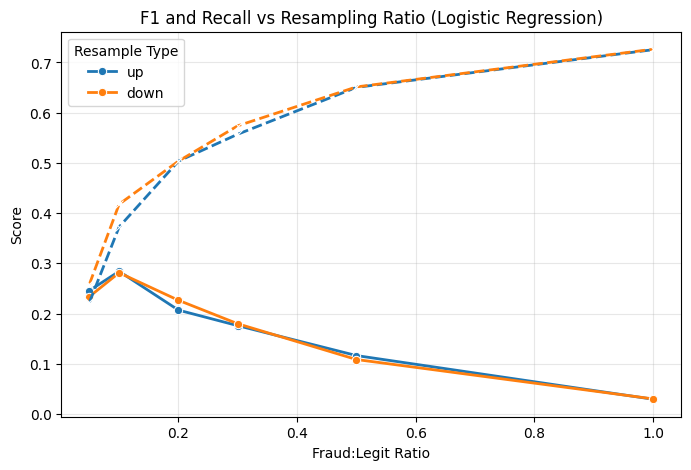

Plots saved to /results directory.


In [ ]:
print("\nGenerating plots...")
plt.figure(figsize=(8,5))

sns.lineplot(data=results_df, x="ratio", y="f1", hue="resample_type",
             marker="o", linewidth=2, legend="brief")

sns.lineplot(data=results_df, x="ratio", y="recall", hue="resample_type",
             marker="x", linestyle="--", linewidth=2, legend=False)

plt.title("F1 and Recall vs Resampling Ratio (Logistic Regression)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Resample Type")
plt.savefig("results/logreg_f1_recall_plot.png")
plt.show()

print("Plots saved to /results directory.")